# 🔁 LSTM Model for Forecasting Temperature, Humidity, PM2.5, and PM10

This notebook trains an LSTM model using past time series data from outdoor environmental sensors.

**Targets:**
- Temperature
- Humidity
- PM2.5
- PM10

**Inputs:**
- 6-hour lag of: temperature, humidity, pm2.5, pm10, wind speed
- Time features: hour, day of week

---

In [54]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping



In [55]:
def load_outdoor_data():
    # Load CSVs
    aqicn = pd.read_csv('data/project_aqicn.csv', parse_dates=['ts'], index_col='ts')
    weather = pd.read_csv('data/project_weather.csv', parse_dates=['ts'], index_col='ts')

    # Rename for consistency
    aqicn = aqicn[['pm25', 'pm10']]
    weather = weather[['wind_speed', 'temperature', 'humidity']]

    # Drop rows with missing values before join (matches the SQL WHERE filter)
    aqicn.dropna(subset=['pm25', 'pm10'], inplace=True)
    weather.dropna(subset=['wind_speed', 'temperature', 'humidity'], inplace=True)

    # Resample both to hourly average
    aqicn = aqicn.resample('1h').mean().interpolate()
    weather = weather.resample('1h').mean().interpolate()

    # Join on timestamp index
    df = aqicn.join(weather, how='inner')

    # Add time features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    return df

# Load the data
df = load_outdoor_data()
df.tail()

,pm25,pm10,wind_speed,temperature,humidity,hour,day_of_week
ts,,,,,,,
2025-04-21 10:00:00,59.0,23.0,4.82,33.41,64.0,10,0
2025-04-21 11:00:00,79.0,30.0,4.90,33.85,61.0,11,0
2025-04-21 12:00:00,69.0,37.0,5.21,34.51,61.0,12,0
2025-04-21 13:00:00,67.0,30.0,5.18,34.58,60.0,13,0
2025-04-21 14:00:00,67.0,24.0,5.03,36.87,50.0,14,0


In [56]:
# 3. Normalize and create sequences
target_cols = ['temperature', 'humidity', 'pm25', 'pm10']
feature_cols = target_cols + ['wind_speed', 'hour', 'day_of_week']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, index=df.index, columns=feature_cols)

def create_sequences(data, target_cols, n_steps=12):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i].values)
        y.append(data.iloc[i][target_cols].values)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, target_cols)
X.shape, y.shape

((555, 12, 7), (555, 4))

In [57]:
# 4. Train/Test split
split_idx = int(len(X) * 0.85)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [58]:
# 5. Build and train LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(Dense(len(target_cols)))
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1
)

Epoch 1/100


c:\Users\taroo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1214 - val_loss: 0.0709
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0250 - val_loss: 0.0343
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - val_loss: 0.0359
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - val_loss: 0.0261
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - val_loss: 0.0237
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - val_loss: 0.0208
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - val_loss: 0.0166
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0159
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0155
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - val_loss: 0.0149
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0141
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - val_l

In [59]:
# 6. Evaluate model
pred = model.predict(X_test)
pred_inv = scaler.inverse_transform(
    np.hstack([pred, np.zeros((pred.shape[0], len(feature_cols) - len(target_cols)))])
)[:, :len(target_cols)]

y_test_inv = scaler.inverse_transform(
    np.hstack([y_test, np.zeros((y_test.shape[0], len(feature_cols) - len(target_cols)))])
)[:, :len(target_cols)]

rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv, multioutput='raw_values'))
mae = mean_absolute_error(y_test_inv, pred_inv, multioutput='raw_values')

for i, col in enumerate(target_cols):
    print(f"🔍 {col.upper()} → RMSE: {rmse[i]:.3f}, MAE: {mae[i]:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
🔍 TEMPERATURE → RMSE: 0.878, MAE: 0.557
🔍 HUMIDITY → RMSE: 12.341, MAE: 6.853
🔍 PM25 → RMSE: 11.543, MAE: 8.930
🔍 PM10 → RMSE: 7.985, MAE: 5.687


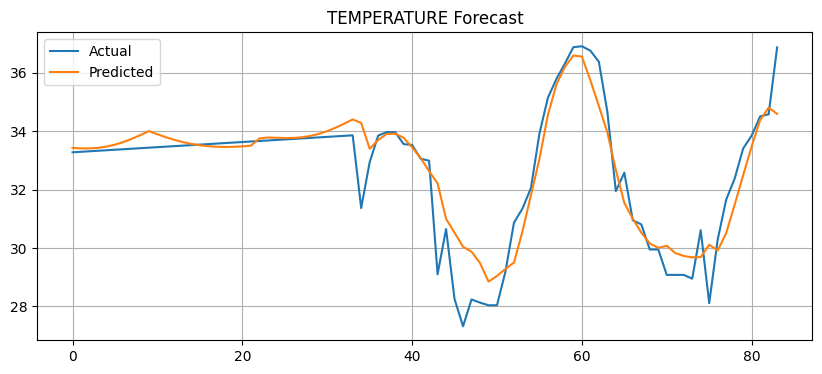

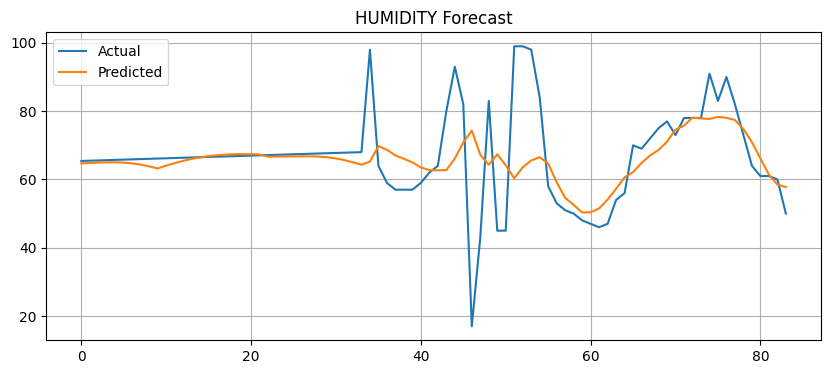

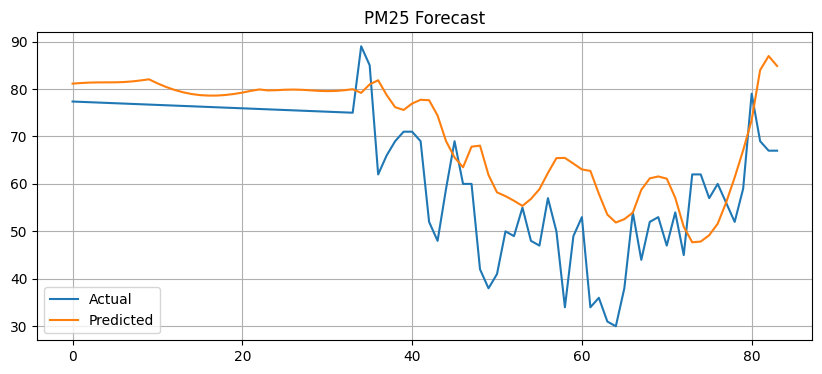

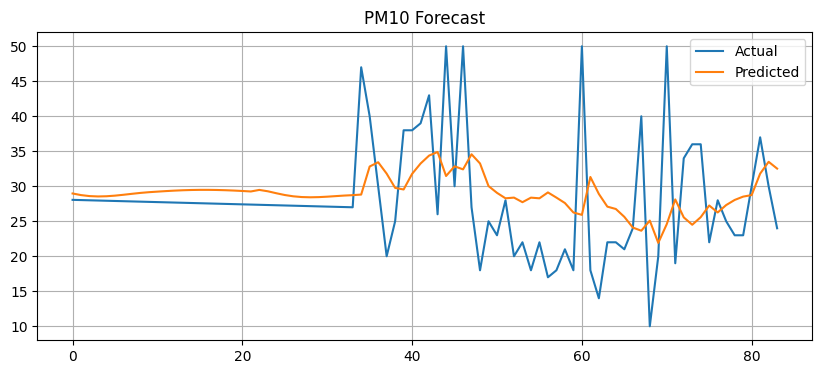

In [60]:
# 7. Plot predictions vs actual
for i, col in enumerate(target_cols):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv[:, i], label='Actual')
    plt.plot(pred_inv[:, i], label='Predicted')
    plt.title(f"{col.upper()} Forecast")
    plt.legend()
    plt.grid()
    plt.show()

In [61]:
# 8. Forecast next 24 hours

n_forecast = 24
last_sequence = scaled_df[-12:].copy()  # last 6 rows
forecast_scaled = []

for _ in range(n_forecast):
    input_seq = np.expand_dims(last_sequence.values, axis=0)
    next_pred = model.predict(input_seq)[0]
    
    # Append only the predicted part, and fake the rest as zeros (hour/day will stay static)
    padded = np.concatenate([next_pred, last_sequence.iloc[-1][['wind_speed', 'hour', 'day_of_week']].values])
    forecast_scaled.append(padded[:len(target_cols)])

    # Append new row to last_sequence for next round
    new_row = np.concatenate([
    next_pred,
    last_sequence.iloc[-1][['wind_speed', 'hour', 'day_of_week']].values
    ])
    new_df = pd.DataFrame([new_row], columns=feature_cols)
    last_sequence = pd.concat([last_sequence, new_df], ignore_index=True).iloc[1:]

# Inverse transform forecast results
forecast_scaled = np.array(forecast_scaled)
forecast_inverse = scaler.inverse_transform(
    np.hstack([forecast_scaled, np.zeros((n_forecast, len(feature_cols) - len(target_cols)))])
)[:, :len(target_cols)]

forecast_df = pd.DataFrame(forecast_inverse, columns=target_cols)
forecast_df['time'] = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')
forecast_df.set_index('time', inplace=True)
pd.set_option('display.max_rows', None)        # show all rows
pd.set_option('display.max_columns', None)     # show all columns

print(forecast_df)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
                     temperature   humidity        pm25       pm10
time                 

C:\Users\taroo\AppData\Local\Temp\ipykernel_50824\1773067167.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_df['time'] = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')


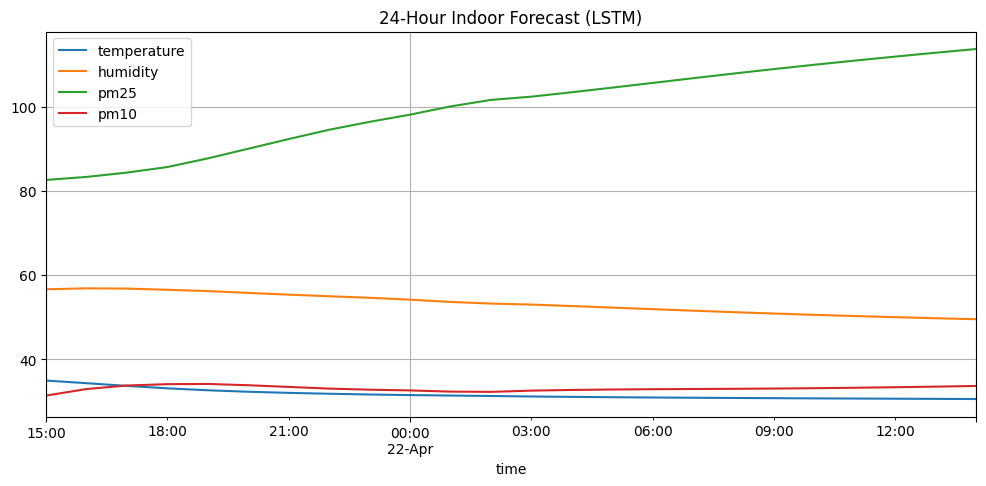

In [62]:
forecast_df.plot(title="24-Hour Indoor Forecast (LSTM)", figsize=(12, 5))
plt.grid()
plt.show()

In [63]:
import joblib

model.save('lstm_outdoor_model.keras')
joblib.dump(scaler, "lstm_outdoor_scaler.pkl")

['lstm_outdoor_scaler.pkl']